#### Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import seaborn as sns
from tqdm import tqdm

In [2]:
from numpy.linalg import eig, svd
from sklearn.decomposition import PCA

In [3]:
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import DataLoader, TensorDataset
from torchvision import datasets, transforms

from torch.optim.lr_scheduler import StepLR, CosineAnnealingLR

#### Test for CUDA

In [4]:
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('No GPU, training on CPU')
    device = torch.device('cpu')
else:
    print('GPU found, training on GPU')
    device = torch.device('cuda')

GPU found, training on GPU


#### Data loader, train and test sets

In [5]:
batch_size = 200

In [6]:
# MNIST dataset
train_dataset = datasets.MNIST(root='./data', train=True, transform=transforms.ToTensor(), download=True)
test_dataset = datasets.MNIST(root='./data', train=False, transform=transforms.ToTensor())

# Data loader
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

In [7]:
# Classes in the MNIST dataset
classes = [str(x) for x in range(10)]
num_classes = len(classes)
classes

['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']

In [8]:
# Print some information about the datasets
print("Number of training examples:", len(train_dataset))
print("Number of test examples:", len(test_dataset))
print("Number of classes:", num_classes)

Number of training examples: 60000
Number of test examples: 10000
Number of classes: 10


#### Model and other hyper-params

In [9]:
# Hyperparameters
input_size = 28  # MNIST image size (28x28)
num_steps = 28
hidden_size = 128
num_layers = 1
num_epochs = 50
learning_rate = 0.001

In [10]:
N = hidden_size ## num. of neurons in RNN

In [11]:
def initialize_weights(N, index_ranges, signs):
    weights = np.zeros((N, N))
    for ii, (start, end) in enumerate(index_ranges):
        limit = 1 / np.sqrt(N) if signs[ii] == 1 else -1/np.sqrt(N)
        weights[:, start:end] = np.random.uniform(0, limit, size=(N, end-start))
    return weights

In [12]:
def generate_mask(weights, index_ranges, signs):
    mask = np.zeros_like(weights)
    for i, (start, end) in enumerate(index_ranges):
        if signs[i] == 1:
            mask[:, start:end] = np.where(weights[:, start:end] > 0, 1, 0)
        elif signs[i] == -1:
            mask[:, start:end] = np.where(weights[:, start:end] < 0, 1, 0)
    return mask

In [13]:
# Define the neural network
class SimpleRNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes, device):
        
        super(SimpleRNN, self).__init__()
        self.hidden_size = hidden_size
        self.rnn = nn.RNN(input_size, hidden_size, num_layers=1, batch_first=True, nonlinearity='tanh')
        self.fc = nn.Linear(hidden_size, num_classes)
        self.n_classes = num_classes
        self.device = device

    def forward(self, x):
        h0 = torch.zeros(1, x.size(0), self.hidden_size).to(x.device)
        nSamp, nSteps, inDim = x.shape
        
        ops = torch.zeros(nSamp,nSteps,self.hidden_size, requires_grad=False).to(self.device)
        pred = torch.zeros(nSamp,nSteps,self.n_classes, requires_grad=False).to(self.device)
        
        for ii in range(nSteps):
            ip = torch.unsqueeze(x[:,ii,:],1)
            op, ht = self.rnn(ip,h0) ## pass 1 timestep through RNN
#             fr_mask = ht.clone()>0
#             htt = fr_mask*ht.clone() ## mask firing rate
            h0 = ht ## update hidden state
            ops[:,ii,:] = torch.squeeze(op.clone())

            ## Final prediction at every timestep
            pred[:,ii,:] = self.fc(ops[:, ii, :].clone())
            
        out = pred[:, -1, :].clone()  #Take the output from the last time step
        
        return out, ht

#### Connectivity and sign constraints

In [14]:
nRuns = 5

In [15]:
frac_ex = 0.8
frac_in = 1-frac_ex

In [16]:
signs = [1,-1]
index_ranges = [(0,int(N*frac_ex)),(int(N*frac_ex),N)]

In [17]:
# Initialize the model
model = {}
weights_init = {}

In [18]:
for cntr in range(nRuns):
    model[cntr] = SimpleRNN(input_size, hidden_size, num_classes, device).to(device)
    weights_init[cntr] = initialize_weights(N,index_ranges,signs)
    model[cntr].rnn.weight_hh_l0.data = torch.from_numpy(weights_init[cntr]).float().to(device)

In [19]:
pp = 1.0
conn_mask = {}
sign_mask = {}
full_mask = {}

In [20]:
for cntr in range(nRuns):
    conn_mask[cntr] = np.random.choice([0, 1], size=(N,N), p=[1-pp, pp])
    sign_mask[cntr] = np.sign(weights_init[cntr])
    sign_mask[cntr][sign_mask[cntr] == 0] = 1
    full_mask[cntr] = torch.from_numpy(sign_mask[cntr]*conn_mask[cntr]).float().to(device)

Text(0.5, 1.0, 'Initial Weights: Conventional RNN')

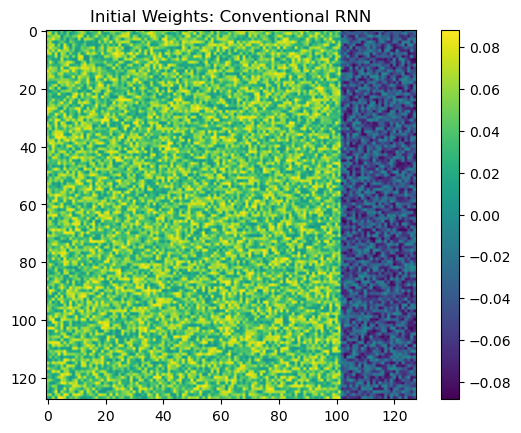

In [21]:
kk = 0

plt.imshow(weights_init[kk])
plt.colorbar()
plt.title('Initial Weights: Conventional RNN')

In [38]:
# Save dictionary to a Numpy .npz file
np.savez('seq_mnist_weights_init_conventional.npz', weights_init, pickle=True)

Text(0, 0.5, 'Counts')

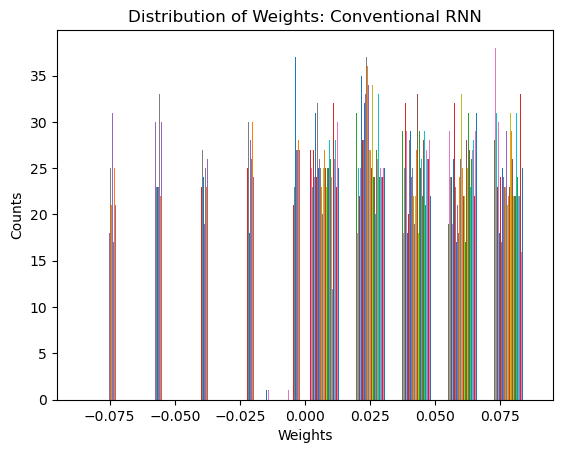

In [22]:
plt.hist(weights_init[kk])
plt.title('Distribution of Weights: Conventional RNN')
plt.xlabel('Weights')
plt.ylabel('Counts')

#### Model training

In [23]:
# Loss and optimizer
criterion = nn.CrossEntropyLoss()

optimizer = {}
for cntr in range(nRuns):
    optimizer[cntr] = optim.Adam(model[cntr].parameters(), lr=learning_rate)

In [24]:
train_losses = np.zeros((nRuns, num_epochs))
test_losses = np.zeros((nRuns, num_epochs))
accuracies = np.zeros((nRuns, num_epochs))

In [25]:
for run in tqdm(range(nRuns)):

    # Training the model
    for epoch in range(num_epochs):
        for ii, (images, labels) in enumerate(train_loader):
            images = images.reshape(-1, 28, 28).to(device)
            labels = labels.to(device)

            # Forward pass
            outputs, firing_rates = model[run](images)
            loss = criterion(outputs, labels)
            train_losses[run,epoch] = loss

            # Backward and optimize
            optimizer[run].zero_grad()
            loss.backward()
            optimizer[run].step()

            ## Rectify weights
#             w = model[run].rnn.weight_hh_l0.detach().cpu().numpy()
#             w[w < 0] = 0
#             model[run].rnn.weight_hh_l0.data = torch.from_numpy(w).float().cuda()

            ## Apply mask
#             model[run].rnn.weight_hh_l0.data = full_mask*model[run].rnn.weight_hh_l0.data

            if (ii+1) % batch_size == 0:
                print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

        # Test the model
        with torch.no_grad():
            correct = 0
            total = 0
            for images_test, labels_test in test_loader:
                images_test = images_test.reshape(-1, 28, 28).to(device)
                labels_test = labels_test.to(device)
                outputs_test, firing_rates_test = model[run](images_test)
                loss_test = criterion(outputs_test, labels_test)
                test_losses[run,epoch] = loss_test
                ## accuracy
                _, predicted = torch.max(outputs_test.data, 1)
                total += labels_test.size(0)
                correct += (predicted == labels_test).sum().item()

            print(f'Accuracy of the network on the test images: {100 * correct / total}%')
            accuracies[run,epoch] = 100 * correct / total

  0%|          | 0/5 [00:00<?, ?it/s]C:\Users\abalwani6\AppData\Local\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:509: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\cudnn\RNN.cpp:982.)
  result = _VF.rnn_tanh(input, hx, self._flat_weights, self.bias, self.num_layers,


Epoch [1/50], Loss: 2.3179
Accuracy of the network on the test images: 11.35%
Epoch [2/50], Loss: 1.4349
Accuracy of the network on the test images: 45.71%
Epoch [3/50], Loss: 1.4596
Accuracy of the network on the test images: 51.4%
Epoch [4/50], Loss: 1.2872
Accuracy of the network on the test images: 58.56%
Epoch [5/50], Loss: 0.9760
Accuracy of the network on the test images: 67.25%
Epoch [6/50], Loss: 0.8895
Accuracy of the network on the test images: 70.15%
Epoch [7/50], Loss: 0.7608
Accuracy of the network on the test images: 74.55%
Epoch [8/50], Loss: 0.8432
Accuracy of the network on the test images: 77.86%
Epoch [9/50], Loss: 0.5311
Accuracy of the network on the test images: 80.61%
Epoch [10/50], Loss: 0.7477
Accuracy of the network on the test images: 78.31%
Epoch [11/50], Loss: 0.3956
Accuracy of the network on the test images: 83.62%
Epoch [12/50], Loss: 0.3750
Accuracy of the network on the test images: 87.98%
Epoch [13/50], Loss: 0.3701
Accuracy of the network on the tes

 20%|██        | 1/5 [32:49<2:11:16, 1969.23s/it]

Accuracy of the network on the test images: 96.34%
Epoch [1/50], Loss: 2.3139
Accuracy of the network on the test images: 11.35%
Epoch [2/50], Loss: 1.6754
Accuracy of the network on the test images: 34.66%
Epoch [3/50], Loss: 1.3353
Accuracy of the network on the test images: 52.5%
Epoch [4/50], Loss: 1.1018
Accuracy of the network on the test images: 69.74%
Epoch [5/50], Loss: 0.7119
Accuracy of the network on the test images: 82.63%
Epoch [6/50], Loss: 0.5076
Accuracy of the network on the test images: 87.11%
Epoch [7/50], Loss: 0.5336
Accuracy of the network on the test images: 89.61%
Epoch [8/50], Loss: 0.3177
Accuracy of the network on the test images: 89.79%
Epoch [9/50], Loss: 0.3322
Accuracy of the network on the test images: 90.92%
Epoch [10/50], Loss: 0.2959
Accuracy of the network on the test images: 91.4%
Epoch [11/50], Loss: 0.2309
Accuracy of the network on the test images: 92.19%
Epoch [12/50], Loss: 0.2802
Accuracy of the network on the test images: 92.58%
Epoch [13/50

 40%|████      | 2/5 [1:05:25<1:38:04, 1961.48s/it]

Accuracy of the network on the test images: 96.95%
Epoch [1/50], Loss: 2.3086
Accuracy of the network on the test images: 11.35%
Epoch [2/50], Loss: 1.5249
Accuracy of the network on the test images: 51.17%
Epoch [3/50], Loss: 0.9239
Accuracy of the network on the test images: 67.43%
Epoch [4/50], Loss: 0.7296
Accuracy of the network on the test images: 75.48%
Epoch [5/50], Loss: 0.5934
Accuracy of the network on the test images: 82.5%
Epoch [6/50], Loss: 0.6327
Accuracy of the network on the test images: 86.88%
Epoch [7/50], Loss: 0.4109
Accuracy of the network on the test images: 88.13%
Epoch [8/50], Loss: 0.3737
Accuracy of the network on the test images: 89.13%
Epoch [9/50], Loss: 0.4886
Accuracy of the network on the test images: 90.57%
Epoch [10/50], Loss: 0.2982
Accuracy of the network on the test images: 91.06%
Epoch [11/50], Loss: 0.3310
Accuracy of the network on the test images: 92.3%
Epoch [12/50], Loss: 0.3813
Accuracy of the network on the test images: 91.11%
Epoch [13/50

 60%|██████    | 3/5 [1:37:53<1:05:10, 1955.49s/it]

Accuracy of the network on the test images: 95.92%
Epoch [1/50], Loss: 2.2961
Accuracy of the network on the test images: 10.11%
Epoch [2/50], Loss: 2.1517
Accuracy of the network on the test images: 34.4%
Epoch [3/50], Loss: 1.3351
Accuracy of the network on the test images: 46.87%
Epoch [4/50], Loss: 1.1850
Accuracy of the network on the test images: 56.87%
Epoch [5/50], Loss: 0.9118
Accuracy of the network on the test images: 70.82%
Epoch [6/50], Loss: 0.7060
Accuracy of the network on the test images: 79.44%
Epoch [7/50], Loss: 0.5714
Accuracy of the network on the test images: 85.5%
Epoch [8/50], Loss: 0.3977
Accuracy of the network on the test images: 90.17%
Epoch [9/50], Loss: 0.3647
Accuracy of the network on the test images: 91.81%
Epoch [10/50], Loss: 0.2314
Accuracy of the network on the test images: 92.44%
Epoch [11/50], Loss: 0.2685
Accuracy of the network on the test images: 93.36%
Epoch [12/50], Loss: 0.2289
Accuracy of the network on the test images: 93.97%
Epoch [13/50

 80%|████████  | 4/5 [2:10:17<32:31, 1951.03s/it]  

Accuracy of the network on the test images: 97.35%
Epoch [1/50], Loss: 2.3052
Accuracy of the network on the test images: 29.02%
Epoch [2/50], Loss: 1.3985
Accuracy of the network on the test images: 52.71%
Epoch [3/50], Loss: 0.9916
Accuracy of the network on the test images: 68.62%
Epoch [4/50], Loss: 0.6949
Accuracy of the network on the test images: 76.81%
Epoch [5/50], Loss: 0.6264
Accuracy of the network on the test images: 79.88%
Epoch [6/50], Loss: 0.5342
Accuracy of the network on the test images: 83.18%
Epoch [7/50], Loss: 0.4705
Accuracy of the network on the test images: 84.44%
Epoch [8/50], Loss: 0.3546
Accuracy of the network on the test images: 85.34%
Epoch [9/50], Loss: 0.2462
Accuracy of the network on the test images: 91.13%
Epoch [10/50], Loss: 0.2148
Accuracy of the network on the test images: 92.65%
Epoch [11/50], Loss: 0.3171
Accuracy of the network on the test images: 93.02%
Epoch [12/50], Loss: 0.2971
Accuracy of the network on the test images: 92.86%
Epoch [13/

100%|██████████| 5/5 [2:42:45<00:00, 1953.16s/it]

Accuracy of the network on the test images: 97.69%


In [26]:
weights_final = {}
for cntr in range(nRuns):
    weights_final[cntr] = model[cntr].rnn.weight_hh_l0.detach().cpu().numpy()

In [43]:
# Save dictionary to a Numpy .npz file
np.savez('seq_mnist_weights_final_conventional.npz', weights_final, pickle=True)

Text(0.5, 1.0, 'Final Weights')

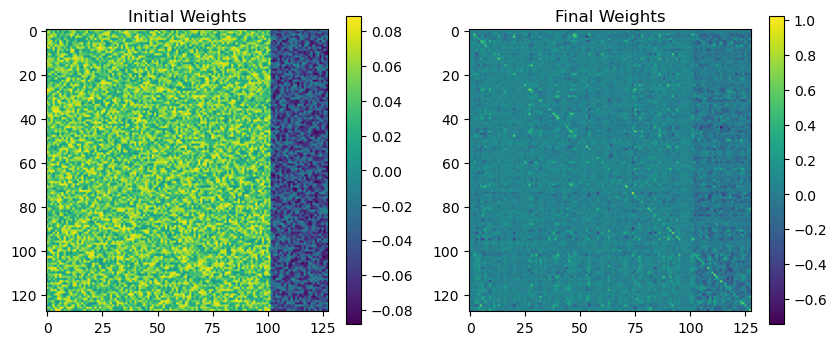

In [41]:
kk = 0

plt.figure(figsize=(10,4))
plt.subplot(121)
plt.imshow(weights_init[kk])
plt.colorbar()
plt.title('Initial Weights')

plt.subplot(122)
plt.imshow(weights_final[kk])
plt.colorbar()
plt.title('Final Weights')

Text(0, 0.5, 'Counts')

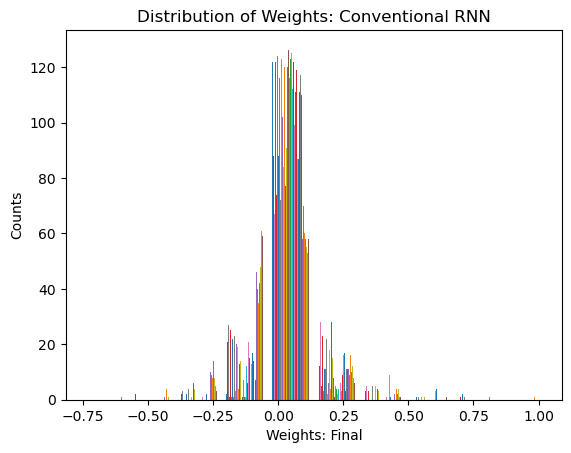

In [31]:
plt.hist(weights_final[kk])
plt.title('Distribution of Weights: Conventional Backprop')
plt.xlabel('Weights: Final')
plt.ylabel('Counts')

In [44]:
## Save train, test losses + accuracies
np.save('seq_mnist_train_losses_conventional_backprop',train_losses)
np.save('seq_mnist_test_losses_conventional_backprop',test_losses)
np.save('seq_mnist_accuracies_conventional_backprop',accuracies)

In [28]:
mean_train_losses = np.mean(train_losses, axis=0)
variance_train_losses = np.var(train_losses, axis=0)

mean_test_losses = np.mean(test_losses, axis=0)
variance_test_losses = np.var(test_losses, axis=0)

mean_accs = np.mean(accuracies, axis=0)
variance_accs = np.var(accuracies, axis=0)

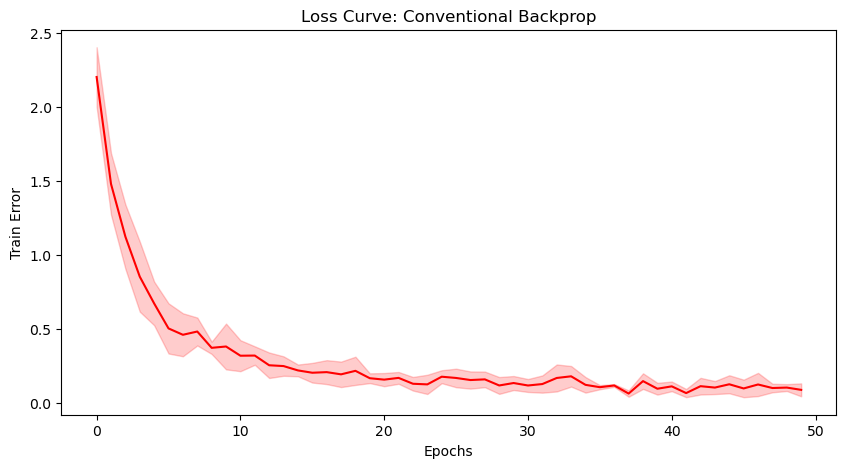

In [32]:
# Define x-axis (epochs)
x = np.arange(num_epochs)

# Plot shaded error bar using Seaborn
plt.figure(figsize=(10, 5))
sns.lineplot(x=x, y=mean_train_losses, color='r')
plt.fill_between(x, mean_train_losses - np.sqrt(variance_train_losses), mean_train_losses + np.sqrt(variance_train_losses),
                 color='r', alpha=0.2)

# sns.lineplot(x=x, y=mean_test_losses, color='r')
# plt.fill_between(x, mean_test_losses - np.sqrt(variance_test_losses), mean_test_losses + np.sqrt(variance_test_losses),
#                  color='r', alpha=0.2)

# Add labels and title
plt.xlabel('Epochs')
plt.ylabel('Train Error')
plt.title('Loss Curve: Conventional Backprop')

# Show plot
plt.show()

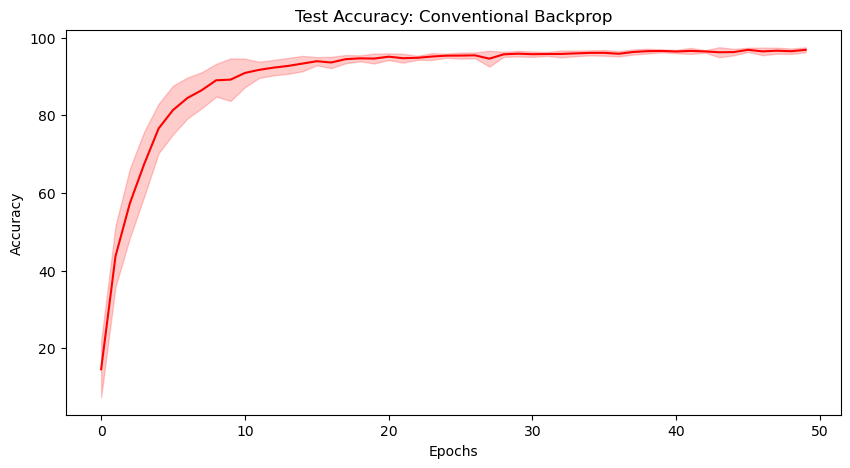

In [33]:
# Define x-axis (epochs)
x = np.arange(num_epochs)

# Plot shaded error bar using Seaborn
plt.figure(figsize=(10, 5))
sns.lineplot(x=x, y=mean_accs, color='r')
plt.fill_between(x, mean_accs - np.sqrt(variance_accs), mean_accs + np.sqrt(variance_accs),
                 color='r', alpha=0.2)

# Add labels and title
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Test Accuracy: Conventional Backprop')

# Show plot
plt.show()